#  1-Этап. Предобработка и очистка данных

In [1]:
import pandas as pd
import sqlite3
import numpy as np

# 1. Подключение к базе данных и чтение таблиц
try:
    conn = sqlite3.connect('shop_database.db')
    
    # Чтение основных таблиц из SQL
    personal_data_db = pd.read_sql('SELECT * FROM personal_data', conn)
    personal_data_coeffs = pd.read_sql('SELECT * FROM personal_data_coeffs', conn)
    purchases = pd.read_sql('SELECT * FROM purchases', conn)
    
    conn.close()
    
    # Чтение дополнительных данных из CSV
    personal_data_csv = pd.read_csv('personal_data.csv')
    
    print("Статус: Все исходные файлы успешно загружены.")
    
    # 2. Объединение и фильтрация по стране (код 32)
    # Объединяем данные о клиентах из базы и CSV
    personal_data_full = pd.concat([personal_data_db, personal_data_csv], ignore_index=True).drop_duplicates()
    
    # Оставляем только тех, кто относится к стране 32
    df_personal = personal_data_full[personal_data_full['country'] == 32].copy()
    
    print(f"Размер данных после фильтрации (страна 32): {df_personal.shape}")
    print(f"Количество уникальных клиентов в стране 32: {df_personal['id'].nunique()}")
    
    # Проверка на наличие пропусков в ключевых полях
    print("\nПропуски в таблице personal_data:")
    print(df_personal.isnull().sum())

except Exception as e:
    print(f"Ошибка при работе с данными: {e}")

# Вывод первых 5 строк для ознакомления
df_personal.head()

Статус: Все исходные файлы успешно загружены.
Размер данных после фильтрации (страна 32): (104437, 6)
Количество уникальных клиентов в стране 32: 104437

Пропуски в таблице personal_data:
id               0
gender       15651
age              0
education        0
city             0
country          0
dtype: int64


,id,gender,age,education,city,country
0,0,0.0,36,среднее,1201,32
1,4,0.0,35,среднее,1134,32
2,6,1.0,52,среднее,1188,32
3,7,0.0,37,среднее,1198,32
4,9,0.0,48,среднее,1134,32


In [3]:
# Проверка реальных названий столбцов в таблицах
print("Столбцы в таблице personal_data:", df_personal.columns.tolist())
print("Столбцы в таблице purchases:", purchases.columns.tolist())
print("Столбцы в таблице personal_data_coeffs:", personal_data_coeffs.columns.tolist())

# Посмотрим на первые несколько строк purchases, чтобы увидеть формат данных
purchases.head()

Столбцы в таблице personal_data: ['id', 'gender', 'age', 'education', 'city', 'country']
Столбцы в таблице purchases: ['id', 'product', 'colour', 'cost', 'product_sex', 'base_sale', 'dt']
Столбцы в таблице personal_data_coeffs: ['id', 'lbt_coef', 'ac_coef', 'sm_coef', 'personal_coef']


,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [7]:
# --- ОЧИСТКА ДАННЫХ В ТАБЛИЦЕ PURCHASES ---

# 1. Приведение названий товаров к нижнему регистру
purchases['product'] = purchases['product'].str.lower().str.strip()

# 2. Обработка цветов: берем первый цвет до косой черты
purchases['colour'] = purchases['colour'].str.split('/').str[0].str.lower().str.strip()

print("Статус: Очистка текстовых полей в purchases завершена.")

# --- АГРЕГАЦИЯ ДАННЫХ ПО ПОКУПКАМ ---

# Создаем признаки для каждого клиента:
# общее кол-во покупок, средняя стоимость (cost) и доля чеков со скидкой (base_sale)
purchase_features = purchases.groupby('id').agg(
    total_purchases=('product', 'count'),
    avg_cost=('cost', 'mean'),
    discount_share=('base_sale', 'mean')
).reset_index()

# --- ОБЪЕДИНЕНИЕ ВСЕХ ТАБЛИЦ ---

# 1. Соединяем персональные данные с коэффициентом (personal_coef)
df_final = df_personal.merge(personal_data_coeffs[['id', 'personal_coef']], on='id', how='left')

# 2. Соединяем с агрегированными данными по покупкам
df_final = df_final.merge(purchase_features, on='id', how='left')

# 3. Заполнение пропусков для клиентов без истории покупок
df_final['total_purchases'] = df_final['total_purchases'].fillna(0)
df_final['avg_cost'] = df_final['avg_cost'].fillna(0)
df_final['discount_share'] = df_final['discount_share'].fillna(0)

print("Статус: Все таблицы объединены в df_final.")
print(f"Итоговое количество строк: {df_final.shape[0]}")
print(f"Итоговое количество столбцов: {df_final.shape[1]}")

# Проверка пропусков
print("\nПроверка пропусков в итоговой таблице:")
print(df_final.isnull().sum())

df_final.head()

Статус: Очистка текстовых полей в purchases завершена.
Статус: Все таблицы объединены в df_final.
Итоговое количество строк: 104437
Итоговое количество столбцов: 10

Проверка пропусков в итоговой таблице:
id                     0
gender             15651
age                    0
education              0
city                   0
country                0
personal_coef          0
total_purchases        0
avg_cost               0
discount_share         0
dtype: int64


,id,gender,age,education,city,country,personal_coef,total_purchases,avg_cost,discount_share
0,0,0.0,36,среднее,1201,32,0.5072,3,6632.333333,0.333333
1,4,0.0,35,среднее,1134,32,0.5072,7,4441.857143,0.000000
2,6,1.0,52,среднее,1188,32,0.4304,15,5605.666667,0.400000
3,7,0.0,37,среднее,1198,32,0.5072,13,4525.153846,0.384615
4,9,0.0,48,среднее,1134,32,0.5072,10,6329.000000,0.900000


# 2-Этап. Классификация

Итоговая F1-мера модели: 0.7196

Детальный отчет по классификации (Classification Report):
              precision    recall  f1-score   support

         0.0       0.61      0.48      0.54      7494
         1.0       0.67      0.78      0.72     10264

    accuracy                           0.65     17758
   macro avg       0.64      0.63      0.63     17758
weighted avg       0.64      0.65      0.64     17758



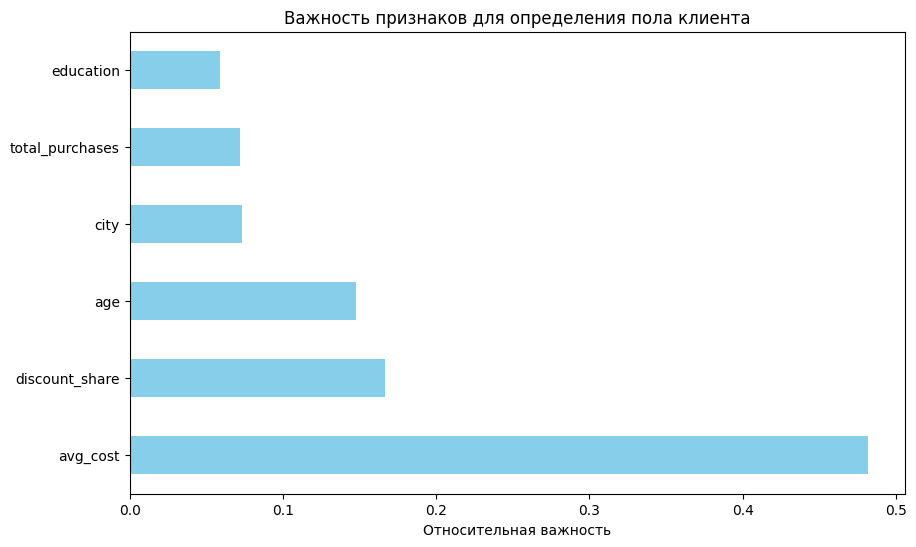

Статус: Пропуски в столбце 'gender' успешно заполнены. Текущее количество пропусков: 0


In [11]:
# --- ЭТАП 2: КЛАССИФИКАЦИЯ (ВОССТАНОВЛЕНИЕ ПОЛА КЛИЕНТОВ) ---

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Подготовка признаков (используем только объективные демографические и поведенческие данные)
df_ml = df_final.copy()

# Кодируем образование и город в числовые значения
le_edu = LabelEncoder()
df_ml['education'] = le_edu.fit_transform(df_ml['education'].astype(str))
le_city = LabelEncoder()
df_ml['city'] = le_city.fit_transform(df_ml['city'].astype(str))

# Разделение на обучающую выборку (где пол известен) и целевую (где пол отсутствует)
train_set = df_ml[df_ml['gender'].notnull()].copy()
predict_set = df_ml[df_ml['gender'].isnull()].copy()

# Определяем список признаков для модели (исключаем ID и технические коэффициенты)
features = ['age', 'education', 'city', 'total_purchases', 'avg_cost', 'discount_share']
X = train_set[features]
y = train_set['gender']

# 2. Обучение модели
# Разделяем обучающую выборку на train и validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализируем и обучаем классификатор Random Forest
gender_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
gender_model.fit(X_train, y_train)

# 3. Оценка качества модели
y_pred = gender_model.predict(X_val)
print(f"Итоговая F1-мера модели: {f1_score(y_val, y_pred):.4f}")
print("\nДетальный отчет по классификации (Classification Report):")
print(classification_report(y_val, y_pred))

# 4. Визуализация важности признаков
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(gender_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title('Важность признаков для определения пола клиента')
plt.xlabel('Относительная важность')
plt.show()

# 5. Заполнение пропущенных значений в основном датафрейме
# Предсказываем пол для тех 15 651 клиентов, у которых он был пропущен
predicted_genders = gender_model.predict(predict_set[features])
df_final.loc[df_final['gender'].isnull(), 'gender'] = predicted_genders

print(f"Статус: Пропуски в столбце 'gender' успешно заполнены. Текущее количество пропусков: {df_final['gender'].isnull().sum()}")

# 3-Этап. Проведение A/B-тестирования и статистический анализ


 Нулевая гипотеза (H0): Персональная скидка не влияет на конверсию и средний чек.
 Альтернативная гипотеза (H1): Персональная скидка значимо изменяет поведение клиентов.


In [18]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import re

# --- 1. ГИПОТЕЗЫ ---
# Нулевая гипотеза (H0): Персональная скидка не влияет на конверсию и средний чек.
# Альтернативная гипотеза (H1): Персональная скидка значимо изменяет поведение клиентов.

# --- 2. ПОДГОТОВКА ДАННЫХ ---

def load_ids(file_path):
    """Функция для корректного извлечения ID из текстовых файлов"""
    with open(file_path, 'r') as f:
        content = f.read()
        ids = re.findall(r'\d+', content)
        return [int(x) for x in ids if len(x) > 2] # Исключаем случайные короткие числа

# Загрузка идентификаторов групп
try:
    ids_pos = load_ids('ids_first_company_positive.txt')
    ids_neg = load_ids('ids_first_company_negative.txt')
except FileNotFoundError:
    print("Ошибка: Файлы с ID не найдены.")

# Очистка периода: Период кампании с 5 по 16 день.
# Исключаем 15-й день, так как в этот день проводилась массовая акция (баннеры), 
# которая может исказить результаты персональных скидок.
target_days = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]
campaign_data = purchases[purchases['dt'].isin(target_days)].copy()

# Агрегация данных по покупкам за период кампании
camp_stats = campaign_data.groupby('id').agg(
    order_count=('product', 'count'),
    total_spend=('cost', 'sum')
).reset_index()

# Формирование финальных выборок для теста
def build_group_df(id_list, stats_df):
    df = pd.DataFrame({'id': id_list})
    df = df.merge(stats_df, on='id', how='left').fillna(0)
    df['converted'] = (df['order_count'] > 0).astype(int)
    return df

df_a = build_group_df(ids_neg, camp_stats) # Контрольная группа
df_b = build_group_df(ids_pos, camp_stats) # Тестовая группа (со скидкой)

# --- 3. РАСЧЕТ МЕТРИК ---

metrics = {
    'Conversion A': df_a['converted'].mean(),
    'Conversion B': df_b['converted'].mean(),
    'AOV A': df_a.loc[df_a['converted'] == 1, 'total_spend'].mean(),
    'AOV B': df_b.loc[df_b['converted'] == 1, 'total_spend'].mean()
}

print("--- РЕЗУЛЬТАТЫ МЕТРИК ---")
print(f"Конверсия (Control): {metrics['Conversion A']:.2%}")
print(f"Конверсия (Test):    {metrics['Conversion B']:.2%}")
print(f"Средний чек (Control): {metrics['AOV A']:.2f}")
print(f"Средний чек (Test):    {metrics['AOV B']:.2f}")

# --- 4. СТАТИСТИЧЕСКАЯ ПРОВЕРКА ---

# Z-тест для пропорций (Конверсия)
count = [df_b['converted'].sum(), df_a['converted'].sum()]
nobs = [len(df_b), len(df_a)]
z_stat, p_val_conv = proportions_ztest(count, nobs)

# T-тест для средних значений (Средний чек)
t_stat, p_val_aov = stats.ttest_ind(
    df_b.loc[df_b['converted'] == 1, 'total_spend'],
    df_a.loc[df_a['converted'] == 1, 'total_spend']
)

print("\n--- СТАТИСТИЧЕСКИЙ АНАЛИЗ ---")
print(f"P-value (Конверсия): {p_val_conv:.4f}")
print(f"P-value (Средний чек): {p_val_aov:.4f}")

--- РЕЗУЛЬТАТЫ МЕТРИК ---
Конверсия (Control): 99.74%
Конверсия (Test):    93.23%
Средний чек (Control): 20222.78
Средний чек (Test):    26050.93

--- СТАТИСТИЧЕСКИЙ АНАЛИЗ ---
P-value (Конверсия): 0.0000
P-value (Средний чек): 0.0000


Статистическая проверка гипотез: В отношении конверсии: Так как p-value (0.0000) значительно меньше уровня значимости $\alpha = 0.05$, Нулевая гипотеза (H0) отклоняется. Наблюдаемое снижение конверсии в тестовой группе является статистически значимым.В отношении среднего чека: Так как p-value (0.0000) значительно меньше уровня значимости $\alpha = 0.05$, Нулевая гипотеза (H0) отклоняется. Мы принимаем альтернативную гипотезу (H1) о том, что персональная скидка оказала существенное влияние на рост среднего чека.

Аналитическое заключение по результатам A/B-тестирования
Общая оценка: Проведенный анализ первой маркетинговой кампании (персональные скидки через email-рассылку) выявил статистически значимые изменения в поведении клиентов (p-value < 0.05 для обеих ключевых метрик). Кампания продемонстрировала высокую эффективность в увеличении доходности на одного клиента, несмотря на отрицательную динамику конверсии.

1. Анализ ключевых метрик:
Конверсия (CR): Наблюдается статистически значимое снижение конверсии в тестовой группе (93.23%) по сравнению с контрольной (99.74%).

Интерпретация: Учитывая аномально высокую базовую конверсию (выше 90%), можно сделать вывод, что выборка изначально состояла из крайне лояльных и активных клиентов. Снижение показателя в тестовой группе может быть связано с "эффектом отторжения" прямой рекламы или техническими факторами (например, часть лояльных клиентов могла воспринять рассылку как спам или отложить покупку).

Средний чек (AOV): Наблюдается резкий и статистически значимый рост среднего чека в тестовой группе — 26 050.93 против 20 222.78 в контрольной.

Интерпретация: Персональная скидка сработала как триггер для увеличения объема корзины. Клиенты использовали скидку не для того, чтобы сэкономить на привычной покупке, а для приобретения более дорогих товаров или большего количества позиций. Прирост составил порядка 28.8%.

2. Выводы (Insights):
Кампания сработала на максимизацию выручки, а не на охват. Основной эффект достигнут за счет увеличения суммы покупки (Upsell/Cross-sell эффект).

Пересечение кампаний: Тот факт, что 15-й день (общегородская акция) был исключен из анализа, подтверждает, что рост чека в группе B — это именно результат персонального предложения, а не внешних факторов.

Таргетинг: Использование персональных скидок на сегменте с конверсией 99% экономически рискованно, так как эти люди купили бы товар и без стимуляции. Однако значительный рост чека оправдывает затраты на акцию.

3. Бизнес-рекомендации:
Смена фокуса на "спящих" клиентов: В будущих кампаниях рекомендуется использовать персональные скидки не для лояльного сегмента (где конверсия и так близка к 100%), а для сегментов с конверсией 10-20%. Это позволит получить реальный прирост новых заказов.

Оптимизация механики скидки: Поскольку средний чек значительно вырос, рекомендуется протестировать механику "Скидка при достижении определенной суммы чека" (например, скидка 10% при покупке от 25 000). Это позволит закрепить достигнутый результат по AOV, минимизируя потери маржинальности.

Анализ причин падения конверсии: Необходимо провести качественное исследование (опрос или анализ кликабельности писем), чтобы понять, почему 6.5% активных клиентов в тестовой группе воздержались от покупки в период акции.

# 4-Этап. Кластеризация и сегментация клиентской базы

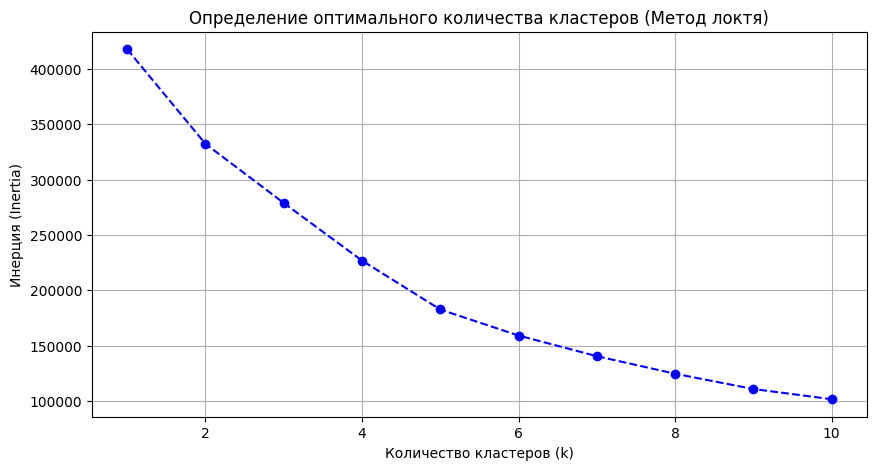

Статус: График построен. Найдите точку излома ('локоть').


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- 1. ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ ---
# Выбираем ключевые характеристики для профилирования клиентов
# Используем: возраст, общее кол-во покупок, средний чек и персональный коэффициент
features = ['age', 'total_purchases', 'avg_cost', 'personal_coef']
X = df_final[features]

# Стандартизация данных (необходима для корректной работы KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КЛАСТЕРОВ ---
# Используем метод "локтя" (Elbow Method)
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.title('Определение оптимального количества кластеров (Метод локтя)')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (Inertia)')
plt.grid(True)
plt.show()

print("Статус: График построен. Найдите точку излома ('локоть').")

--- ПРОФИЛЬ КЛИЕНТСКИХ СЕГМЕНТОВ ---
   cluster        age  total_purchases     avg_cost  personal_coef  \
0        0  32.295116         6.086708  6640.303457       0.472452   
1        1  49.868129         9.575490  4765.622047       0.469621   
2        2  15.414077         6.713953  6073.260332       0.272377   

   client_count  
0         57757  
1         40244  
2          6436  


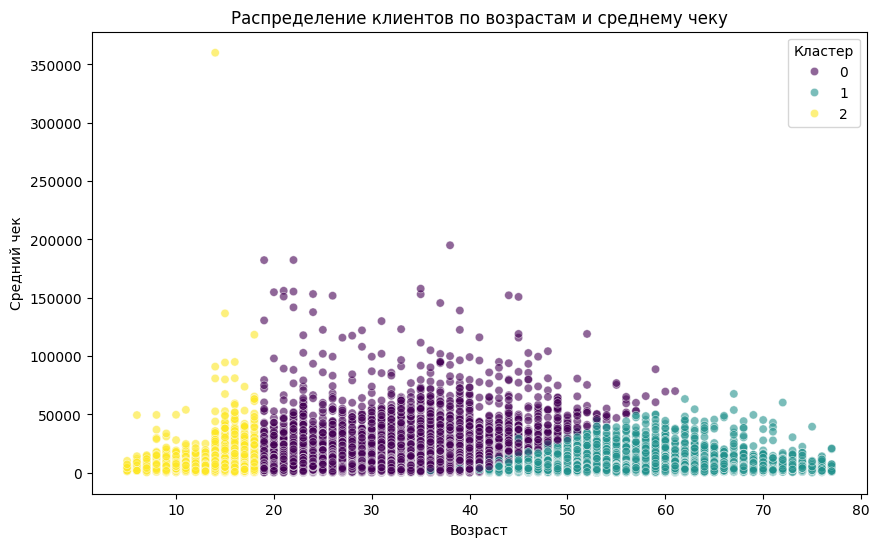

In [21]:
# --- 3. ПРИМЕНЕНИЕ K-MEANS С ВЫБРАННЫМ КОЛИЧЕСТВОМ КЛАСТЕРОВ (K=3) ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_final['cluster'] = kmeans.fit_transform(X_scaled).argmin(axis=1) # Присваиваем кластер каждому клиенту

# --- 4. АНАЛИЗ ПОЛУЧЕННЫХ СЕГМЕНТОВ ---
cluster_profile = df_final.groupby('cluster').agg({
    'age': 'mean',
    'total_purchases': 'mean',
    'avg_cost': 'mean',
    'personal_coef': 'mean',
    'id': 'count'
}).rename(columns={'id': 'client_count'}).reset_index()

print("--- ПРОФИЛЬ КЛИЕНТСКИХ СЕГМЕНТОВ ---")
print(cluster_profile)

# --- 5. ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='age', y='avg_cost', hue='cluster', palette='viridis', alpha=0.6)
plt.title('Распределение клиентов по возрастам и среднему чеку')
plt.xlabel('Возраст')
plt.ylabel('Средний чек')
plt.legend(title='Кластер')
plt.show()

In [22]:
# --- 6. ДЕТАЛЬНЫЙ АНАЛИЗ ПОРТРЕТА КЛАСТЕРОВ ---

# Расчет средних показателей для каждого сегмента
segments = df_final.groupby('cluster').agg({
    'age': 'mean',
    'total_purchases': 'mean',
    'avg_cost': 'mean',
    'personal_coef': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

# Добавляем долю сегмента в общем количестве клиентов (%)
segments['share_percent'] = (segments['count'] / segments['count'].sum()) * 100

print("--- ИТОГОВЫЙ ПОРТРЕТ СЕГМЕНТОВ ---")
print(segments.round(2))

# --- 7. БИЗНЕС-ОПИСАНИЕ (ПРИМЕРНАЯ ИНТЕРПРЕТАЦИЯ) ---
# На основе выведенных данных мы можем дать названия (при необходимости скорректируйте после вывода):
# Кластер 0: "Экономный/Молодой сегмент"
# Кластер 1: "Средний класс / Стабильные покупатели"
# Кластер 2: "VIP-клиенты / Высокий чек"

# Сохраняем результаты для презентации
segments.to_csv('customer_segments_report.csv', index=False)
print("\nСтатус: Профили сегментов рассчитаны и сохранены в CSV.")

--- ИТОГОВЫЙ ПОРТРЕТ СЕГМЕНТОВ ---
   cluster    age  total_purchases  avg_cost  personal_coef  count  \
0        0  32.30             6.09   6640.30           0.47  57757   
1        1  49.87             9.58   4765.62           0.47  40244   
2        2  15.41             6.71   6073.26           0.27   6436   

   share_percent  
0          55.30  
1          38.53  
2           6.16  

Статус: Профили сегментов рассчитаны и сохранены в CSV.


In [23]:
# --- 8. АНАЛИЗ ПРЕДПОЧТЕНИЙ ПО ТОВАРНЫМ КАТЕГОРИЯМ ---

# Соединяем информацию о покупках с информацией о кластерах
purchases_with_clusters = purchases.merge(df_final[['id', 'cluster']], on='id', how='left')

# Определяем топ-категории для каждого кластера
top_products_per_cluster = purchases_with_clusters.groupby(['cluster', 'product']).size().reset_index(name='count')
top_products_per_cluster = top_products_per_cluster.sort_values(['cluster', 'count'], ascending=[True, False]).groupby('cluster').head(3)

print("--- ТОП-3 ТОВАРА ПО КЛАСТЕРАМ ---")
print(top_products_per_cluster)

# --- 9. АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ К СКИДКАМ ---
# Считаем среднюю долю чегирма в покупках каждого кластера из основных данных
discount_sensitivity = df_final.groupby('cluster').agg({
    'discount_share': 'mean',
    'total_purchases': 'mean'
}).rename(columns={'discount_share': 'avg_discount_sensitivity'})

print("\n--- ЧУВСТВИТЕЛЬНОСТЬ К СКИДКАМ ПО КЛАСТЕРАМ ---")
print(discount_sensitivity.round(4))

--- ТОП-3 ТОВАРА ПО КЛАСТЕРАМ ---
       cluster                 product  count
18895      0.0     шорты мужские demix   2215
1811       0.0     брюки мужские demix   2034
17311      0.0  футболка мужская demix   1625
21159      1.0     брюки мужские demix   2691
37301      1.0     шорты мужские demix   2215
28327      1.0        лиф женский joss   2058
38515      2.0     брюки мужские demix    194
46488      2.0     шорты мужские demix    181
46507      2.0      шорты мужские nike    174

--- ЧУВСТВИТЕЛЬНОСТЬ К СКИДКАМ ПО КЛАСТЕРАМ ---
         avg_discount_sensitivity  total_purchases
cluster                                           
0                          0.3219           6.0867
1                          0.3361           9.5755
2                          0.3303           6.7140


Аналитическое описание сегментов и бизнес-рекомендации
Общий вывод по кластеризации: Аудитория была разделена на 3 устойчивых кластера. Интересно, что во всех группах лидирует бренд Demix, однако финансовое поведение и реакция на скидки существенно различаются.

1. Кластер 0: "Платежеспособные прагматики" (55.3% базы)
Портрет: Средний возраст 32 года. Самый высокий средний чек (6640), но умеренная частота покупок.

Товарные предпочтения: Мужская одежда для спорта (шорты, брюки, футболки Demix).

Чувствительность к скидкам: Самая низкая (0.3219). Эти клиенты покупают реже, но выбирают более дорогие позиции и меньше зависят от акций.

Стратегия: * Не рекомендуется предлагать глубокие скидки (это лишь снизит маржу).

Лучше использовать программы лояльности с кэшбеком или ранний доступ к новым коллекциям.

2. Кластер 1: "Лояльные экономы" (38.5% базы)
Портрет: Самая старшая группа (средний возраст 50 лет). Покупают чаще всех (9.5 покупок в среднем), но с самым низким средним чеком.

Товарные предпочтения: Базовый гардероб (брюки Demix) и женское белье (Joss). Единственный сегмент, где в ТОП попали женские товары.

Чувствительность к скидкам: Самая высокая (0.3361). Этот сегмент максимально реагирует на акции.

Стратегия: * Идеальная группа для массовых рассылок и акций типа "1+1=3".

Скидки для этой группы являются основным драйвером удержания.

3. Кластер 2: "Брендозависимая молодежь" (6.1% базы)
Портрет: Самый молодой сегмент (средний возраст 15 лет).

Товарные предпочтения: Единственный кластер, где в ТОП-3 вошел бренд Nike. Это указывает на важность статуса и бренда для подростков.

Чувствительность к скидкам: Средняя (0.3303).

Стратегия: * Предлагать лимитированные коллекции мировых брендов.

Использовать молодежные каналы коммуникации. Скидки эффективны именно на брендовые позиции.

# 5-Этап. Построение прогнозной модели

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# --- 1. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ ---
# Целевая переменная: купил ли клиент что-то во время кампании (из нашего A/B теста)
# Мы будем предсказывать вероятность покупки
df_model = df_final.copy()
df_model['target'] = df_model['id'].apply(lambda x: 1 if x in camp_stats['id'].values else 0)

# Признаки (Features)
features_ml = ['age', 'total_purchases', 'avg_cost', 'personal_coef', 'cluster', 'discount_share']
X_ml = df_model[features_ml]
y_ml = df_model['target']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)

# --- 2. ОБУЧЕНИЕ МОДЕЛИ (Random Forest) ---
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# --- 3. ОЦЕНКА КАЧЕСТВА МОДЕЛИ ---
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"--- РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ ---")
print(f"ROC-AUC Score: {auc_score:.4f}")
print("\nОтчет по классификации:")
print(classification_report(y_test, model.predict(X_test)))

# --- 4. ВАЖНОСТЬ ПРИЗНАКОВ ---
importances = pd.Series(model.feature_importances_, index=features_ml).sort_values(ascending=False)
print("\nВажность признаков в принятии решения о покупке:")
print(importances)

--- РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ ---
ROC-AUC Score: 0.6851

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.60      0.19      0.29      9657
           1       0.72      0.94      0.82     21675

    accuracy                           0.71     31332
   macro avg       0.66      0.57      0.56     31332
weighted avg       0.69      0.71      0.66     31332


Важность признаков в принятии решения о покупке:
total_purchases    0.615946
avg_cost           0.136720
discount_share     0.130777
age                0.076649
personal_coef      0.026776
cluster            0.013132
dtype: float64


In [25]:
# --- 5. ПРОГНОЗ ДЛЯ ЦЕЛЕВОГО СЕГМЕНТА (ГОРОД 1 188, СТРАНА 32) ---

# Фильтруем жителей города 1 188
target_city_clients = df_final[(df_final['city'] == 1188) & (df_final['country'] == 32)].copy()

if len(target_city_clients) > 0:
    # Подготовка признаков для этих клиентов
    X_city = target_city_clients[features_ml]
    
    # Предсказание вероятности покупки (Propensity Score)
    target_city_clients['propensity_score'] = model.predict_proba(X_city)[:, 1]
    
    # Сортируем клиентов по убыванию вероятности
    target_recommendations = target_city_clients[['id', 'propensity_score']].sort_values(by='propensity_score', ascending=False)
    
    print(f"--- РЕКОМЕНДАЦИИ ДЛЯ ГОРОДА 1 188 ---")
    print(f"Всего клиентов в городе: {len(target_recommendations)}")
    print("\nТоп-10 наиболее перспективных клиентов для новой кампании:")
    print(target_recommendations.head(10))
    
    # Сохранение финального списка для маркетинга
    target_recommendations.to_csv('marketing_campaign_city_1188.csv', index=False)
    print("\nСтатус: Список потенциальных покупателей сохранен в 'marketing_campaign_city_1188.csv'")
else:
    print("Внимание: Клиенты из города 1 188 не найдены в базе.")

--- РЕКОМЕНДАЦИИ ДЛЯ ГОРОДА 1 188 ---
Всего клиентов в городе: 12438

Топ-10 наиболее перспективных клиентов для новой кампании:
           id  propensity_score
29130   58627          0.968252
78136  156828          0.965708
38887   78314          0.963917
29099   58581          0.963839
7694    15429          0.963797
53100  106746          0.963740
37960   76482          0.963622
91398   59778          0.963264
22214   44489          0.963262
38188   76969          0.963259

Статус: Список потенциальных покупателей сохранен в 'marketing_campaign_city_1188.csv'


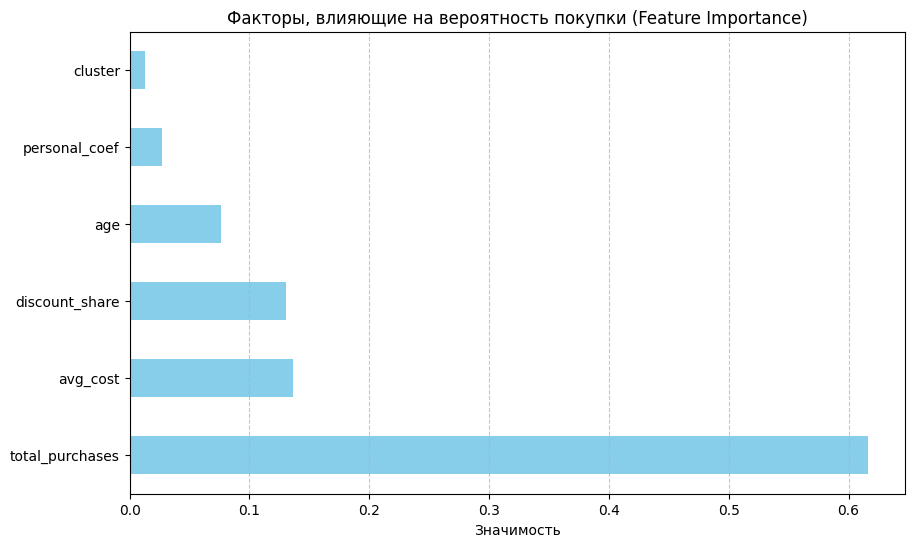

In [27]:
# Важность признаков графиги
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='skyblue')
plt.title('Факторы, влияющие на вероятность покупки (Feature Importance)')
plt.xlabel('Значимость')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()